# Introduction to Compositional Data Analysis

Questions we'd like to answer

1. Differential abundance
2. Microbe correlation
3. Community separation (PCoA)*



The Problem
- Sparsity
- Compositionality *

# Urn analogy

<img src="images/urn.jpg">

- Balls = microbes
- Colors = microbial taxa
- Bucket = environment (i.e. human gut)

Suppose

You are collecting two samples, one sample at time point 1 and another sample at time point 2.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from skbio.stats.composition import closure  # normalizes samples to add to 1.
from skbio import DistanceMatrix
from scipy.spatial.distance import euclidean
%matplotlib inline

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


<Container object of 10 artists>

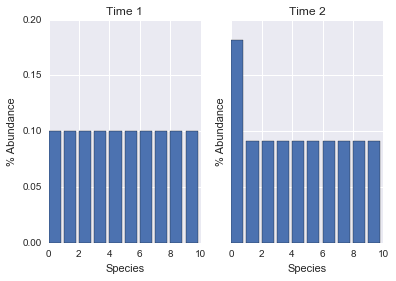

In [2]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.set_title('Time 1')
ax2.set_title('Time 2')
ax1.set_xlabel('Species')
ax2.set_xlabel('Species')
ax1.set_ylabel('% Abundance')
ax2.set_ylabel('% Abundance')

proportion_x1 = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
proportion_x2 = np.array([0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
proportion_x2 = proportion_x2 / proportion_x2.sum()
ax1.bar(range(10), proportion_x1)
ax2.bar(range(10), proportion_x2)

One possibility is that the first species doubled in absolute abundance.

<Container object of 10 artists>

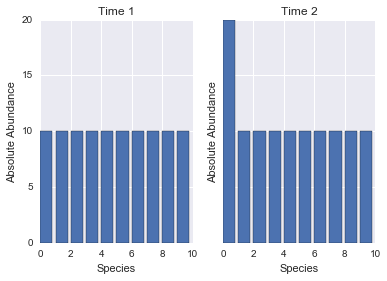

In [3]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.set_title('Time 1')
ax2.set_title('Time 2')
ax1.set_xlabel('Species')
ax2.set_xlabel('Species')
ax1.set_ylabel('Absolute Abundance')
ax2.set_ylabel('Absolute Abundance')

scenario1_x1 = np.array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10])
scenario1_x2 = np.array([20] + [10, 10, 10, 10, 10, 10, 10, 10, 10])
ax1.bar(range(10), scenario1_x1)
ax2.bar(range(10), scenario1_x2)

The other possibility is that the rest of the species halved in absolute abundance.

(0, 20)

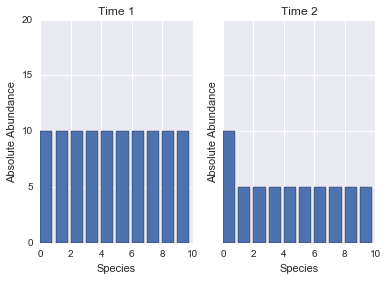

In [4]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.set_title('Time 1')
ax2.set_title('Time 2')
ax1.set_xlabel('Species')
ax2.set_xlabel('Species')
ax1.set_ylabel('Absolute Abundance')
ax2.set_ylabel('Absolute Abundance')

scenario2_x1 = np.array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10]) 
scenario2_x2 = np.array([10] + [5, 5, 5, 5, 5, 5, 5, 5, 5])
ax1.bar(range(10), scenario2_x1)
ax2.bar(range(10), scenario2_x2)
ax1.set_ylim([0, 20])
ax2.set_ylim([0, 20])

The absolute abundances in Time 2 are completely different, but they yield the same proportions.

This property is known as __scale invariance__.  Specifically if you have two samples $x$ and $y$ and the following relationship holds

$$
y = \lambda x
$$

where $\lambda > 0$, then you are dealing with compositional data.  

This happens whenever 
- you have to subsample from a large environment (think of a human gut)
- cannot measure the total quantity in the environment (think of an ocean)

Because of this phenomenon, it is impossible to infer

1. What species grew and declined
2. What species changes

just based on relative abundances alone.

To appreciate how difficult this is, consider the following scenario.

In [5]:
D = 1000   # number of species
S = 10     # number of different samples
N = 10000  # sequencing depth
R = 30     # number of replicates
otu_ids = ["O%d"%i for i in range(D)]
sample_ids = ["S%d"%i for i in range(S)]
data = [[1000]*D]
for a in np.logspace(0, 5, S-1):
    data.append([1000*a] + [1000]*(D-1))
table = pd.DataFrame(data, columns=otu_ids, index=sample_ids)

In [6]:
table

,O0,O1,O2,O3,O4,O5,O6,O7,O8,O9,...,O990,O991,O992,O993,O994,O995,O996,O997,O998,O999
S0,1.000000e+03,1000,1000,1000,1000,1000,1000,1000,1000,1000,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
S1,1.000000e+03,1000,1000,1000,1000,1000,1000,1000,1000,1000,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
S2,4.216965e+03,1000,1000,1000,1000,1000,1000,1000,1000,1000,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
S3,1.778279e+04,1000,1000,1000,1000,1000,1000,1000,1000,1000,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
S4,7.498942e+04,1000,1000,1000,1000,1000,1000,1000,1000,1000,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
S5,3.162278e+05,1000,1000,1000,1000,1000,1000,1000,1000,1000,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
S6,1.333521e+06,1000,1000,1000,1000,1000,1000,1000,1000,1000,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
S7,5.623413e+06,1000,1000,1000,1000,1000,1000,1000,1000,1000,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
S8,2.371374e+07,1000,1000,1000,1000,1000,1000,1000,1000,1000,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
S9,1.000000e+08,1000,1000,1000,1000,1000,1000,1000,1000,1000,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000


Let's extract 30 replicates from each sample
- 300 samples all together

Now let's run a statistical test of 
- Replicates in S(0) versus S(i)
- S(i) = sample i

Here, we'll run the tests across all OTUs to see if it is different.

In [7]:
fdr = []
for i in range(1, S):
    sample1 = np.random.multinomial(N, closure(table.iloc[0, :].values), size=R)
    sample2 = np.random.multinomial(N, closure(table.iloc[i, :].values), size=R)
    t, p = scipy.stats.ttest_ind(sample1, sample2)
    fdr.append((p[1:]<0.05).sum())

Now we'll plot the results to see what the false discovery rate looks like.

In [8]:
x = range(i)
labels = np.logspace(0, 5, S-1)
labels = ["%.2f" % a for a in labels]

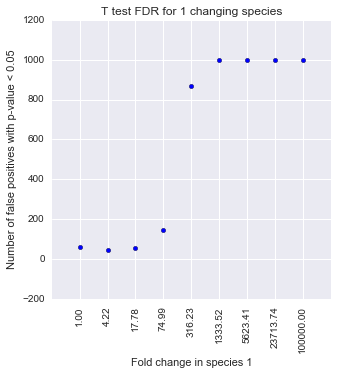

In [9]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(x, fdr)
_ = plt.xticks(x, labels, rotation=90)
plt.ylabel('Number of false positives with p-value < 0.05')
plt.xlabel('Fold change in species 1')
plt.title('T test FDR for 1 changing species')

From here, it appears that when species 1 has increased by 3 orders of magnitude, it will appear as if everything has changed.

What about Mann-Whitney?

In [10]:
fdr = []
for i in range(1, S):
    sample1 = np.random.multinomial(N, closure(table.iloc[0, :].values), size=R)
    sample2 = np.random.multinomial(N, closure(table.iloc[i, :].values), size=R)
    p = np.array([scipy.stats.mannwhitneyu(sample1[:, i], sample2[:, i]).pvalue for i in range(D)])
    fdr.append((p[1:]<0.05).sum())

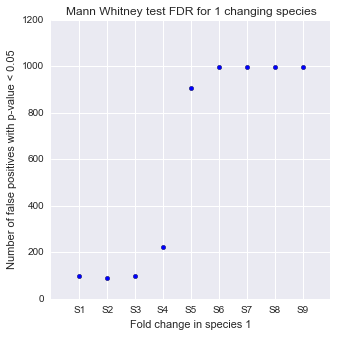

In [11]:
fig = plt.figure(figsize=(5, 5))
x = range(i)
plt.scatter(x, fdr)
_ = plt.xticks(x, sample_ids[1:])
plt.ylabel('Number of false positives with p-value < 0.05')
plt.xlabel('Fold change in species 1')
plt.title('Mann Whitney test FDR for 1 changing species')

This is actually not unrealistic
 - blooms do happen frequently. 

In summary - using univariate tests can result in high false positives

This is because proportions are unstable quantities to estimate.

# Scaling

<Container object of 100 artists>

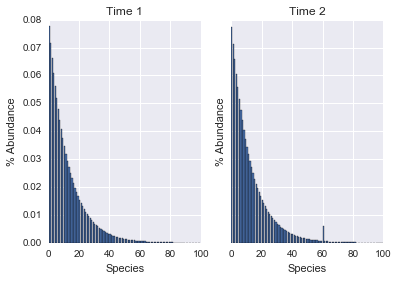

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.set_title('Time 1')
ax2.set_title('Time 2')
ax1.set_xlabel('Species')
ax2.set_xlabel('Species')
ax1.set_ylabel('% Abundance')
ax2.set_ylabel('% Abundance')
N = 10000
num_species = 100
scenario2_x1 = np.exp(-np.linspace(0, 8, num_species))
scenario2_x2 = np.exp(-np.linspace(0, 8, num_species))
scenario2_x2[60] *= 10

scenario2_x1 = scenario2_x1 / scenario2_x1.sum()
scenario2_x2 = scenario2_x2 / scenario2_x2.sum()

ax1.bar(range(num_species), scenario2_x1)
ax2.bar(range(num_species), scenario2_x2)

In [21]:
samples = []
reps = 30
sample1 = np.random.multinomial(N, scenario2_x1, size=reps) / N
sample2 = np.random.multinomial(N, scenario2_x2, size=reps) / N
samples = np.vstack((sample1, sample2))

dm = DistanceMatrix.from_iterable(samples, metric=euclidean)
dm = pd.DataFrame(dm.data, index=dm.ids, columns=dm.ids)

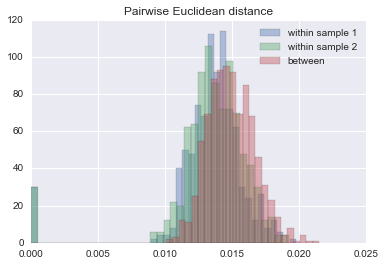

In [22]:
f, ax = plt.subplots()
sample1_var = np.ravel(dm.iloc[:30, :30].values)
sample2_var = np.ravel(dm.iloc[30:, 30:].values)
between_var = np.ravel(dm.iloc[30:, :30].values)
sns.distplot(sample1_var, ax=ax, kde=False, label='within sample 1')
sns.distplot(sample2_var, ax=ax, kde=False, label='within sample 2')
sns.distplot(between_var, ax=ax, kde=False, label='between')
plt.legend(loc=0)
plt.title('Pairwise Euclidean distance')

<Container object of 100 artists>

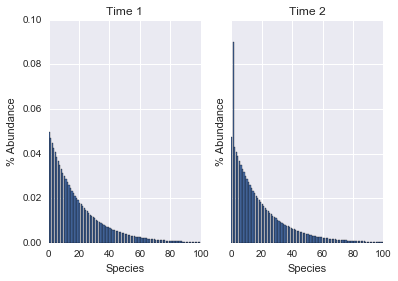

In [23]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.set_title('Time 1')
ax2.set_title('Time 2')
ax1.set_xlabel('Species')
ax2.set_xlabel('Species')
ax1.set_ylabel('% Abundance')
ax2.set_ylabel('% Abundance')
N = 10000
scenario2_x1 = np.exp(-np.linspace(0, 5, num_species))
scenario2_x2 = np.exp(-np.linspace(0, 5, num_species))
scenario2_x2[1] *= 2

scenario2_x1 = scenario2_x1 / scenario2_x1.sum()
scenario2_x2 = scenario2_x2 / scenario2_x2.sum()

ax1.bar(range(num_species), scenario2_x1)
ax2.bar(range(num_species), scenario2_x2)

In [24]:
samples = []
reps = 30
sample1 = np.random.multinomial(N, scenario2_x1, size=reps) / N
sample2 = np.random.multinomial(N, scenario2_x2, size=reps) / N
samples = np.vstack((sample1, sample2))

dm = DistanceMatrix.from_iterable(samples, metric=euclidean)
dm = pd.DataFrame(dm.data, index=dm.ids, columns=dm.ids)

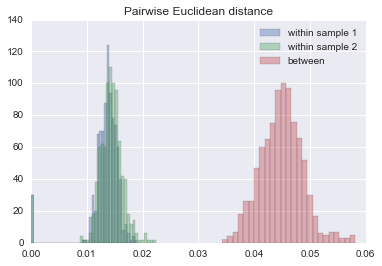

In [25]:
f, ax = plt.subplots()
sample1_var = np.ravel(dm.iloc[:30, :30].values)
sample2_var = np.ravel(dm.iloc[30:, 30:].values)
between_var = np.ravel(dm.iloc[30:, :30].values)
sns.distplot(sample1_var, ax=ax, kde=False, label='within sample 1')
sns.distplot(sample2_var, ax=ax, kde=False, label='within sample 2')
sns.distplot(between_var, ax=ax, kde=False, label='between')
plt.legend(loc=0)
plt.title('Pairwise Euclidean distance')